假设你有一组文档（如PDF、Notion页面、客户问题等），并希望对其内容进行总结。

大型语言模型（LLMs）在理解和综合文本方面表现出色，因此非常适合用来进行总结。

在检索增强生成（retrieval-augmented generation）的应用场景中，文本总结有助于提炼从大量检索到的文档中获取的信息，为LLM提供背景上下文。

在本文中，我们将介绍如何使用LLMs对多个文档的内容进行总结。

![](https://python.langchain.com/assets/images/summarization_use_case_1-874f7b2c94f64216f1f967fb5aca7bc1.png)

# 概述
在构建总结器时，一个核心问题是如何将文档内容传入LLM的上下文窗口。有两种常见的方法：

Stuff（填充法）：将所有文档直接“填充”到一个单一的提示中。这是最简单的方法（更多关于此方法的信息可以参考create_stuff_documents_chain构造器的说明）。

Map-reduce（映射-归约法）：在“映射”步骤中先分别对每个文档进行总结，然后将这些总结“归约”为一个最终的总结（更多关于此方法的信息可以参考MapReduceDocumentsChain的说明）。

需要注意的是，map-reduce方法尤其在理解子文档内容不依赖于前后文时非常有效。例如，在总结一组较短的文档时。如果是像总结小说或具有内在序列关系的文本，[逐步精炼](https://python.langchain.com/docs/how_to/summarize_refine/)的方法可能会更加有效。

![](https://python.langchain.com/assets/images/summarization_use_case_2-f2a4d5d60980a79140085fb7f8043217.png)

In [1]:
from config import *
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='deepseek-v3')

In [2]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


# 填充法：在一次LLM调用中总结
我们可以使用 create_stuff_documents_chain 方法，特别是当使用具有更大上下文窗口的模型时，例如：

128k token 的 OpenAI GPT-4o
200k token 的 Anthropic Claude-3-5-sonnet-20240620
该方法会将文档列表传入，将所有文档插入到一个提示中，然后将这个提示传递给LLM进行处理。

In [8]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

The article "LLM Powered Autonomous Agents" by Lilian Weng explores the concept of using large language models (LLMs) as the core controllers of autonomous agents. These agents are designed to handle complex tasks by integrating planning, memory, and tool use capabilities. Key components of such systems include:

1. **Planning**: Agents break down large tasks into smaller subgoals using techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT), which enhance reasoning and problem-solving. Self-reflection allows agents to learn from past mistakes and refine their actions.

2. **Memory**: Agents utilize short-term memory (in-context learning) and long-term memory (external vector stores) to retain and recall information over time. Techniques like Maximum Inner Product Search (MIPS) enable efficient retrieval of relevant data.

3. **Tool Use**: Agents can interact with external tools and APIs to access additional information, execute code, and perform tasks beyond the model's inhe

## 流式处理
需要注意的是，我们还可以将结果按令牌逐个流式传输：

In [9]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

|The| article| "|LLM Powered Autonomous| Agents" by Lil|ian Weng explores| the concept of using| large language models (|LLMs) as| the core controllers of| autonomous agents. These| agents, exemplified by| projects like AutoGPT|, GPT-Engine|er, and Baby|AGI, demonstrate| the potential of LL|Ms to go beyond| text generation and act| as general problem sol|vers. The article| outlines the key components| of an LLM|-powered agent system:| **planning**,| **memory**, and| **tool use**.|

1. **Planning|**: Agents break down| complex tasks into smaller|, manageable subgo|als and engage in| self-reflection to refine| their actions. Techniques| like Chain of Thought| (CoT)| and Tree of Thoughts| (ToT)| are used to enhance| reasoning and explore multiple| solutions.

2.| **Memory**: Agents| utilize short-term memory| (in-context| learning) and long|-term memory (external| vector stores) to| retain and retrieve information|. Maximum Inner Product| Search (MIPS|) algorithms are employed| for effici

# 映射-归约法：通过并行化总结长文本
我们来详细讲解一下映射-归约法。首先，我们会使用LLM将每个文档映射为一个独立的总结。然后，我们将这些总结进行归约或整合，最终得到一个全局总结。

需要注意的是，映射步骤通常会并行化处理输入的文档。

LangGraph，基于 langchain-core 构建，支持映射-归约工作流，非常适合解决这个问题

## 映射步骤
首先，我们需要定义与映射步骤相关的提示。我们可以使用与填充法（Stuff 方法）中相同的总结提示，如下所示：

In [3]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

我们还可以使用 Prompt Hub 来存储和获取提示。

In [6]:
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")
map_prompt

/mnt/d/Documents/GitHub/learn-langchain/venv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['docs'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'map-prompt', 'lc_hub_commit_hash': 'de4fba345f211a462584fc25b7077e69c1ba6cdcf4e21b7ec9abe457ddb16c87'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['docs'], input_types={}, partial_variables={}, template='The following is a set of documents:\n{docs}\nBased on this list of docs, please identify the main themes \nHelpful Answer:'), additional_kwargs={})])

## 归约步骤
我们还需要定义一个提示，接收文档映射的结果，并将它们归约为一个单一的输出。

In [7]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

## 使用 LangGraph 进行 orchestration（协调）
下面我们实现一个简单的应用程序，首先在文档列表上进行总结映射步骤，然后使用上述提示将它们归约成一个最终输出。

映射-归约流程在文本较长、而LLM的上下文窗口较小时尤其有用。对于较长的文本，我们需要一个机制来确保在归约步骤中，待总结的上下文不会超过模型的上下文窗口大小。

首先，我们将博客文章划分成更小的“子文档”以供映射处理：

In [8]:
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 16 documents.


接下来，定义图（Graph）。

In [13]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
        state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

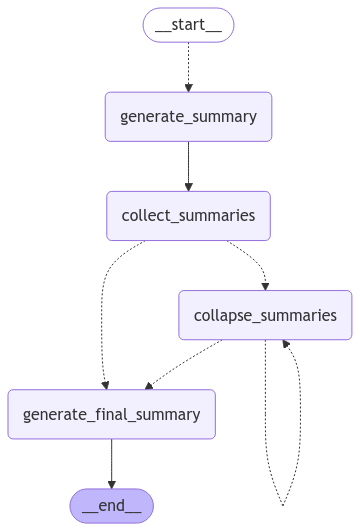

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))